In [1]:
import os

import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np

gpu_on = False

if gpu_on :
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
from gan_module.data_loader.classification import ClassifyDataloader as ClassifyDataloader
from glob import glob

data_set_name = "detect_lvi"
batch_size = 2

train_image_path_list = glob(f"./datasets/{data_set_name}/train/*/*")
valid_image_path_list = glob(f"./datasets/{data_set_name}/valid/*/*")
test_image_path_list = glob(f"./datasets/{data_set_name}/test/*/*")
label_list = os.listdir(f"./datasets/{data_set_name}/train")

label_to_index_dict = {label:index for index, label in enumerate(label_list)}
index_to_label_dict = {index:label for index, label in enumerate(label_list)}
train_data_loader = ClassifyDataloader(image_path_list=train_image_path_list,
                                       label_to_index_dict = label_to_index_dict,
                                       batch_size = batch_size,
                                       shuffle=False
)
valid_data_loader = ClassifyDataloader(image_path_list=valid_image_path_list,
                                       label_to_index_dict = label_to_index_dict,
                                       batch_size = batch_size,
                                       shuffle=False
)
test_data_loader = ClassifyDataloader(image_path_list=test_image_path_list,
                                       label_to_index_dict = label_to_index_dict,
                                       batch_size = batch_size,
                                       shuffle=False
)

In [3]:
from tensorflow.keras.applications import InceptionV3, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.activations import sigmoid
import numpy as np
np.random.seed(1337)  # for reproducibility

DROPOUT_RATIO = 0.5

transfer_learning = True
train_mode = "deep_layer_only"

# create the base pre-trained model
base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=train_data_loader.source_data_shape,
    classes=None,
    pooling=None,
    classifier_activation=None
)

if transfer_learning:
    if train_mode == "dense_only":
        base_model.trainable = False
    elif train_mode == "deep_layer_only":
        for layer in base_model.layers: 
            layer.trainable = False
            if layer.name == "mixed4":
                break

# add a global spatial average pooling layer
x = base_model.output
# (Batch_Size,?)
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATIO)(x)
# let's add a fully-connected layer
# (Batch_Size,1)
x = Dense(1024, activation='relu')(x)
# (Batch_Size,1024)
x = Dropout(DROPOUT_RATIO)(x)
############## MODIFIED!!!!!!! 1 => 2 ##################
predictions = Dense(2, activation='sigmoid')(x)


# this is the model we will train
model = Model(base_model.input, predictions)

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Nadam

loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
optimizer = Nadam(1e-3, clipnorm=1)

# save_c = ModelCheckpoint(
#     "./U_net/weights_{epoch:02d}_{loss:.4f}.hdf5",
#     monitor='val_loss',
#     verbose=0,
#     save_best_only=False,
#     save_weights_only=True,
#     mode='min')

save_c = ModelCheckpoint(
    "./U_net/weights_{epoch:02d}_{loss:.4f}.hdf5",
    monitor='loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='min')


reduceLROnPlat = ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=10,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=5,
    min_lr=1e-9)
csv_logger = CSVLogger('./U_net/log.csv', append=False, separator=',')

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

In [5]:
# start_epoch = 0
# epochs = 200

# model.fit(
#     train_data_loader,
#     validation_data=valid_data_loader,
#     epochs=epochs,
#     callbacks=[reduceLROnPlat, save_c, csv_logger],
#     initial_epoch=start_epoch
# )

# Class Activation Map

In [6]:
import cv2
import os
import numpy as np

def imread(img_path, channel=None):
    img_byte_stream = open(img_path.encode("utf-8"), "rb")
    img_byte_array = bytearray(img_byte_stream.read())
    img_numpy_array = np.asarray(img_byte_array, dtype=np.uint8)
    img_numpy_array = cv2.imdecode(
        img_numpy_array, cv2.IMREAD_UNCHANGED)
    if channel == "rgb":
        img_numpy_array = cv2.cvtColor(
            img_numpy_array, cv2.COLOR_BGR2RGB)
    if len(img_numpy_array.shape) == 2:
        img_numpy_array = np.expand_dims(img_numpy_array, axis=-1)
    return img_numpy_array

from tensorflow import keras
import matplotlib.cm as cm

BASE_DTYPE = "float32"

def get_last_conv_name(model):
    layer_names = [layer.name for layer in model.layers]
    conv_layer_name = [layer_name for layer_name in layer_names if layer_name.find("conv") >= 0]
    last_conv_name = conv_layer_name[-1]
    
    return last_conv_name

def get_img_array(img_path, channel="rgb", dtype=BASE_DTYPE):
    
    img_array = imread(img_path, channel="rgb")
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Model input: model.input
    # Model output: [last_conv_layer_outputs, model.outputs]
    grad_model = keras.models.Model(
        model.input, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # compute
    # 1. last_conv_layer_output
    # 2. class_channel value in prediction
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # compute gradient 
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # compute gradient channel mean 
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # compute matmul(last_conv_layer_output, pooled_grads)
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image.open(cam_path))


def decode_classify_predictions(pred_array, index_to_label_dict):
    predicted_index = np.sum(np.argmax(preds, axis=1))
    predicted = index_to_label_dict[predicted_index]
    
    return predicted

def decode_binary_classify_predictions(pred_array, index_to_label_dict):
    predicted = np.round(pred_array)
    predicted = pred_array.flatten()[0]
    predicted = int(pred_array)
    return predicted

In [7]:
layer_names = [layer.name for layer in model.layers]
conv_layer_name = [layer_name for layer_name in layer_names if layer_name.find("conv") >= 0]
last_conv_name = conv_layer_name[-1]

print(last_conv_name)

conv2d_93


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 511, 511, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 511, 511, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 511, 511, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

./datasets/detect_lvi/test\LVI_positive\175_LVI_positive_13.png


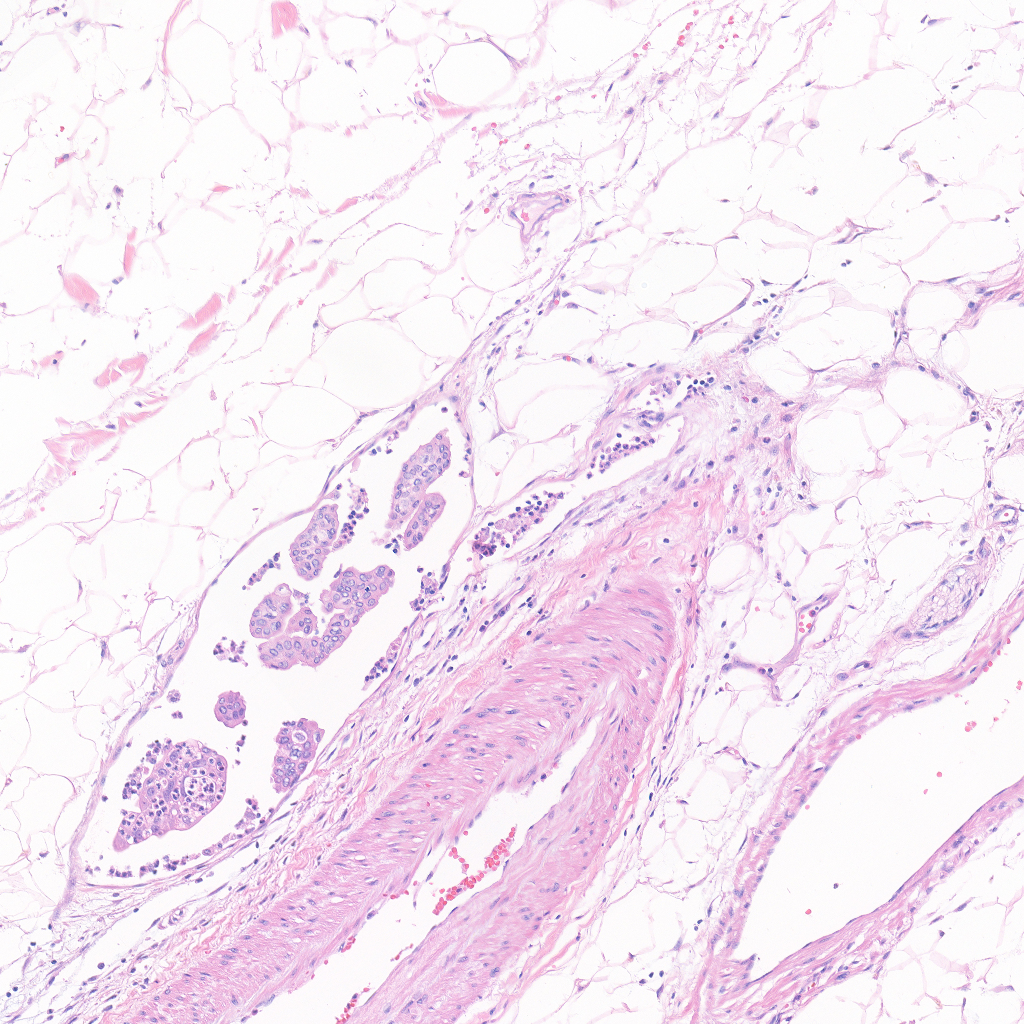

In [23]:
from PIL import Image

img_index = 1234

test_image_path = test_image_path_list[img_index]
print(test_image_path)
display(Image.open(test_image_path))

[[0.06537408 0.91304326]]
Predicted: LVI_positive


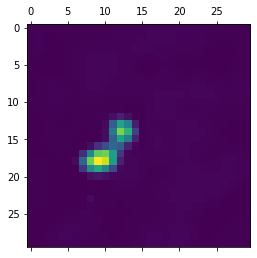

In [26]:
last_conv_layer_name = "mixed10"

from matplotlib import pyplot as plt
# Prepare image
img_array = get_img_array(test_image_path)
# img_array_normalized = preprocess_input(img_array)
img_array_normalized = (img_array / 127.5) - 1
# Make model
model = Model(base_model.input, predictions)
model.load_weights("./U_net/weights_15_0.0717.hdf5")

# Print what the top predicted class is
preds = model.predict(img_array_normalized)
print(preds)
predicted_label = decode_classify_predictions(preds, index_to_label_dict)
pred_index = 1
# pred_index = label_to_index_dict[predicted_label]

print(f"Predicted: {predicted_label}")

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array_normalized, model, last_conv_layer_name, pred_index=pred_index)

# Display heatmap
plt.matshow(heatmap)
plt.show()

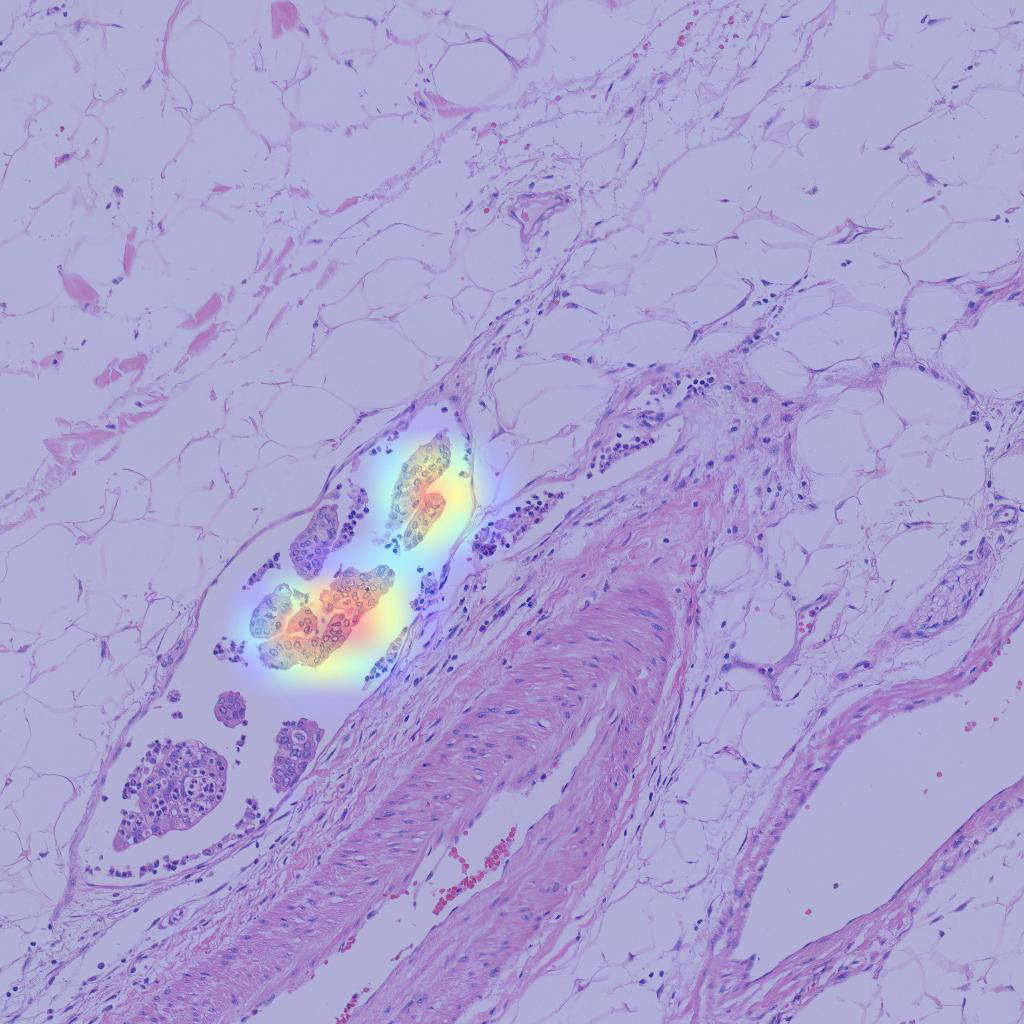

In [27]:
save_and_display_gradcam(test_image_path, heatmap)

In [54]:
from tensorflow.keras.optimizers import Nadam
loss_function = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.01)
optimizer = Nadam(1e-3, clipnorm=1)
model = Model(base_model.input, predictions)
model.load_weights("./U_net/LVI_detect_classfication/weights_1.0_1.0_InceptionV3_Imagenet_LVI_level2/weights_129_0.0012.hdf5")
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
model.evaluate(test_data_loader)

734/734 [==============================] - 598s 812ms/step - loss: 10.8615 - accuracy: 0.5238


[10.861518859863281, 0.5238419771194458]

In [32]:
pred_index=label_to_index_dict[predicted_label]

# First, we create a model that maps the input image to the activations
# of the last conv layer as well as the output predictions
grad_model = keras.models.Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    if pred_index is None:
        pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

# This is the gradient of the output neuron (top predicted or chosen)
# with regard to the output feature map of the last conv layer
grads = tape.gradient(class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
# then sum all the channels to obtain the heatmap class activation
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)